# Chapter 6. Deep Computer Vision

[*Applied Machine Learning for Health and Fitness*](https://www.apress.com/9781484257715) by Kevin Ashley (Apress, 2020).

[*Video Course*](http://ai-learning.vhx.tv) Need a deep dive? Watch my [*video course*](http://ai-learning.vhx.tv) that complements this book with additional examples and video-walkthroughs. 

[*Web Site*](http://activefitness.ai) for research and supplemental materials.


## Neuroscience and deep learning

> Neural networks that were trained to discriminate between different kinds of images have quite a bit of the information needed to generate images too.
>
> Alexander Morvdintsev, author of Deep Dream


![](images/ch6/fig_6-1.jpeg) 


Despite differences, computation results of artificial neural nets and brain are strikingly similar in results, including perception of optical illusions. *Pareidolia* is a well-known phenomenon: most of us will see a human face on this Martian rock formation picture taken by Viking orbiter (Figure 6-2), however from a different angle it looks just like another rock. 

Conveniently, if we apply machine methods for detecting features (such as a smile, on an image of 3 sticks and one circle!), we may get the same results as the human brain. And this face is not even smiling, but it tells me where the smile is supposed to be! The method I use here is well known for facial recognition, it's called Haar Cascades classifier, and is included in OpenCV. Let's see if we can use it to detect a smile!

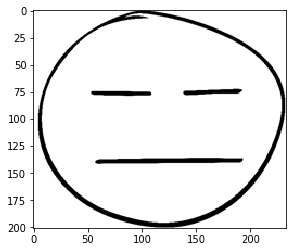

[[ 49 106 143  71]]


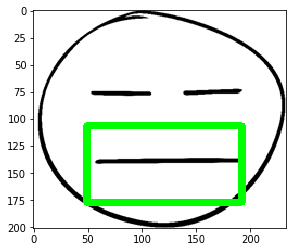

In [23]:
import cv2
import matplotlib.pyplot as plt
import wget

image = cv2.imread('media/face.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')
features = cascade.detectMultiScale(image)
print(features)
for (x, y, w, h) in features:
    img = image.copy()
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 6)
    plt.imshow(img)
    plt.show()


The idea that networks trained to recognize various types of images can also generate images, prompted Alexander Mordvintsev, an engineer from Google to create Deep Dream, a model that generates dream-like bizarre images based on what it learns.

## Computer vision in health and fitness

![](images/ch6/fig_6-4.png) 

## Loading visual datasets

> In data science 90% of time spent finding data and 10% of time spent complaining about collecting the data.
>
> Old data science joke

The first question any data scientist asks is: "Can you give me the data?". Deep learning output is only as good as your training data. In the last few years, datasets evolution made possible many amazing data science applications. We already used some of these datasets (for example COCO), to help us make first steps in sports science, estimating positions of athletes in 2D and 3D and recognizing human activities. Working with multiple images and models in high level frameworks such as PyTorch is simplified, and typically involves loading and transforming data, training the model or using an existing model. For loading, ImageFolder and DatasetFolder are two generic objects that help loading images and data for training and scoring: for example, ImageFolder makes it easy to load image data, stored in folder structure that matches root/class/\*.png and apply transformations:

['surfing', 'tennis']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


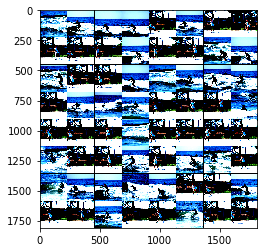

In [29]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler

f = 'data/activities'

def load(f, size = .2):
    
    t = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225])])
        
    train = datasets.ImageFolder(f, transform=t)
    test = datasets.ImageFolder(f, transform=t)
    n = len(train)
    indices = list(range(n))
    split = int(np.floor(size * n))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train,sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load(f, .2)
print(trainloader.dataset.classes)
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.permute(1,2,0))

In the projects that follow we will use this dataset to train the model and classify sport activities. But for now, let's discuss the heart of machine learning, our models!

## Model Zoo

A visit to a city can't be complete without a stop by a local zoo. When I moved to Bay area, my checklist included visiting Golden Gate park and checking out the famous San Francisco zoo. But it turned out, California local wildlife frequented my house anyway, without bothering with property boundaries. I'm also fortunate to live by a running course in golden California hills, established in 1971, where I can observe local animals every day: deer, rabbits, coyotes and occasionally, bobcats.

![](images/ch6/image5.png) 

In data science we have model zoos: collections of pretrained models that can be used for various tasks. Modern frameworks like PyTorch include built-in methods to fetch models and start using them quickly, including those trained for vision, audio and text: conveniently, they are called torchvision, torchaudio and torchtext. Some of them are particularly interesting for us because they work great in sport movement analysis.

## Applying models

Torchvision models include image classification (AlexNet, VGG, ResNet etc), semantic segmentation (FCN ResNet, DeepLabV3), object detection (Faster R-CNN, Mask R-CNN), keypoint detection (Keypoint R-CNN ResNet-50 FPN), video classification (ResNet 3D) etc. You can also create a custom model and add it to the zoo. Models come pretrained (weights included), or blank with random weights.

![](images/ch6/fig_6-5.png) 

Data science applications in sports often require predicting the most efficient way to make movements, and that requires both deep domain knowledge and models. When should we use rules and when machine learning? Machine learning is not the panacea for all problems: oftentimes basic statistical methods or rule-based programming applies best. The rule of thumb is when the problem can be described by simple rules, we can use rules. When rules are hard or impossible to create deterministically, we use machine learning.

Now, we are ready to apply our knowledge to do one of the most fundamental tasks in machine learning: classifying our data!

## Classification

### Project 6-1: Classification of activities

In this project we will classify images from different sporting activities, using Resnet model.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

In the previous sections, we loaded a small set of data, containing 100 images for 2 classes: surfing and tennis. This is not much data to train our model, but fortunately we can use a technique called transfer learning and leverage ImageNet trained on millions of images. Remember, that PyTorch auto-calculates gradients, so for transfer learning we need to freeze gradients by setting requires_grad = False to prevent PyTorch to recalculate gradients during backpropagation: 

In [31]:
for param in model.parameters():
    param.requires_grad = False    

Next, we use a bit of magic here: in data-science speak it's called using ConvNet as fixed feature extractor. It means we'll remove the last fully connected layer that comes with the pretrained model and replace it with only the Linear classifier for 2 classes we need, surfing and tennis:

In [32]:
features = model.fc.in_features
model.fc = nn.Linear(features, len(labels))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

After the model downloads, let's train it on our image data and save the model.

In [33]:
def train_model(epochs=3):
    total_loss = 0
    train_losses, test_losses = [], []
    i = 0
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            i += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(total_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {total_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    return model

model = train_model(epochs=3)
torch.save(model, 'activity_classifier_model.pth')

Epoch 1/3.. Train loss: 5.300.. Test loss: 4.977.. Test accuracy: 0.000
Epoch 1/3.. Train loss: 10.005.. Test loss: 4.589.. Test accuracy: 0.000
Epoch 1/3.. Train loss: 14.474.. Test loss: 4.047.. Test accuracy: 0.000
Epoch 2/3.. Train loss: 18.333.. Test loss: 3.374.. Test accuracy: 0.250
Epoch 2/3.. Train loss: 21.572.. Test loss: 2.626.. Test accuracy: 0.575
Epoch 2/3.. Train loss: 23.993.. Test loss: 1.862.. Test accuracy: 0.675
Epoch 3/3.. Train loss: 25.681.. Test loss: 1.199.. Test accuracy: 0.750
Epoch 3/3.. Train loss: 26.701.. Test loss: 0.717.. Test accuracy: 0.950
Epoch 3/3.. Train loss: 27.350.. Test loss: 0.424.. Test accuracy: 1.000


Let's see the plot of how well our model converges:

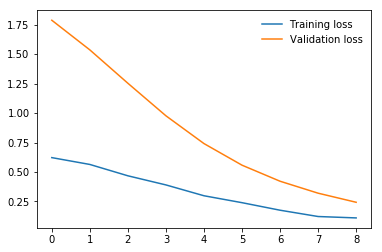

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('fig_6-train-conv.png',dpi=300)

Now, let's see if the model can really tell one activity from another. The result looks pretty good:

1
1
0
1
1


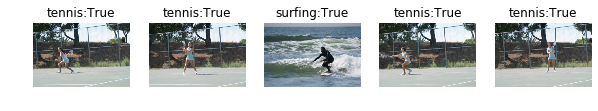

In [8]:
data_dir = 'data/activities/'
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('activity_classifier_model.pth')
model.eval()

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

from torch.autograd import Variable

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.savefig('fig_6-test.png',dpi=300)

## Detection

### Project 6-2 Detection: applying Faster R-CNN model to detect a surfer and a surfboard

The Faster R-CNN model included with PyTorch is trained to predict multiple classes from COCO categories, including sports equipment, such as skis, snowboard, surfboard, tennis racket, baseball glove, skateboard, which makes it pretty useful in sports. We will use Faster R-CNN model to identify a surfboard from this image of the surfer:

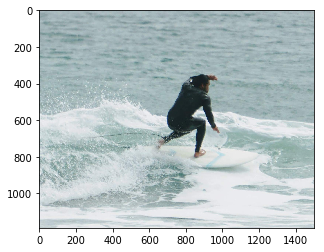

In [35]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
%matplotlib inline

img = Image.open('./media/surfer.jpg')
plt.imshow(img); plt.show()

Let's load the model in PyTorch:

In [30]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

Thanks to torchvision, if we don't have the model, it gets downloaded automatically into .cache:

```
Downloading: \"https://download.pytorch.org/models/fasterrcnn\_resnet50\_fpn\_coco-258fb6c6.pth\" to .cache\\torch\\checkpoints\\fasterrcnn\_resnet50\_fpn\_coco-258fb6c6.pth

100.0%
```

This list of COCO classes was copied from COCO, note that it contains a surfboard!

In [31]:
 COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
        'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
        'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

Next, I created filter\_detections method that runs predictions, based on our model and filters predictions using a threshold of 0.7 confidence (we are not interested in surfboards with confidence level less than 70%)! The result is bounding rectangles for detected instances of a person and a surfboard!

In [33]:
import torchvision.transforms as T

def filter_detections(img, model, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(model.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = model(img_t)[0]
    boxes = pred['boxes']
    box_scores = pred['scores']
    labels = pred['labels']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(COCO_CLASSES[labels[i].cpu().tolist()],boxes[i].cpu().numpy()) for i in idxs]
    return res

detections = filter_detections(img, model)
print(detections)

[('person', array([657.10974, 348.05603, 989.6811 , 788.5723 ], dtype=float32)), ('surfboard', array([ 540.8133 ,  721.37134, 1200.1666 ,  859.6029 ], dtype=float32))]


[657.10974 348.05603 989.6811  788.5723 ]
[ 540.8133   721.37134 1200.1666   859.6029 ]


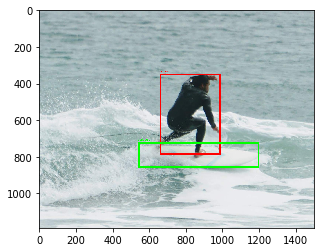

In [34]:
from PIL import Image
from PIL import ImageDraw, ImageFont

def show_detections(img, detections):
    colors = {"surfboard":"lime","person":"red"}
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial",16)
    for d in detections:
        name = d[0]
        box = d[1]
        color = "red"
        print(box)
        if name in colors:
            color = colors[name]
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=8)
        draw.text((box[0], box[1]-24), name, fill=color, font=font)
    return img

img_detections = show_detections(img, detections)
plt.imshow(img_detections); 
#plt.show()
plt.savefig("fig_detect_surfboard.png",dpi=300)

## Segmentation

### Project 6-3: Applying ResNet model for semantic segmentation

In the previous project we detected an instance of an object. Now, we'll play with another model to isolate a segment on the image. This is called semantic segmentation, a method widely used in deep learning and computer vision. To illustrate our very practical use case: selecting an athlete on the image, I'll be using a pretrained FCN ResNet 101 model:

In [36]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Notice pretrained=True flag in the model constructor: I could also choose a blank model without weights, then I would simply specify a constructor without arguments. If you run this line of code for the first time, and the model hasn't been cached yet, torchvision will automatically download and store the model in the cache. Pretty cool, huh? For a data scientist, having to deal with multiple models, that's a relief. To list models available from torchvision for example, run this command:

In [37]:
torch.hub.list('pytorch/vision')

Using cache found in C:\Users\kevinash/.cache\torch\hub\pytorch_vision_master


['alexnet',
 'deeplabv3_resnet101',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'fcn_resnet101',
 'googlenet',
 'inception_v3',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'wide_resnet101_2',
 'wide_resnet50_2']

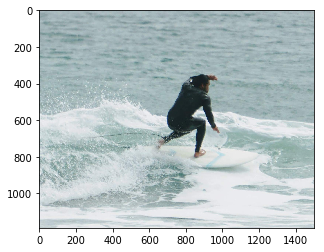

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
%matplotlib inline

img = Image.open('./media/surfer.jpg')
plt.imshow(img); plt.show()

Without a transformation, even humans looking at some images may be confused, let alone our models! Look at the illustration below, for example, and see if you can tell a bunny from a duck without a proper rotation! 

![](images/ch6/fig_6-11.png)

Pretrained models are often expected to have data normalized in the same way: for images in pretrained torchvision models this involves transforming them to 3 channels (RGB) \* h \* w, where h and w are at least 224 pixels in \[0,1\] range and normalizing using specific mean and standard deviation. That's actually pretty cool that models we use can perform tasks using such tiny images!

To transform images in a form that's best suited for pretrained models, we use a composition of several transformations:

In [39]:
# Apply the transformations needed
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)

img_tensor = normalize(img)

In the above sequence of transformations, the image is resized, the cropped to 224 points with Resize and CenterCrop transforms, then the PIL image in the range of \[0,255\] is converted to float tensor (CxHxW) in the range of \[0,1\] with ToTensor() transform, and then normalized. Now, this image is ready for our model:

In [40]:
out = fcn(img_tensor)['out']
out_model = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (out_model.shape)

(224, 224)


and display the result:

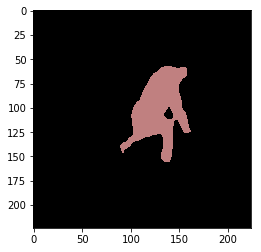

In [41]:
# Define the helper function
def show_segment(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

rgb = show_segment(out_model)
plt.imshow(rgb)
#plt.show()
plt.savefig("fig_seg.png",dpi=300)

## Human body keypoints detection

### Project 6-4: Applying ResNet model to detect human body keypoints

In the previous example, we did semantic segmentation, using a pretrained FCN model. In this project, we'll dive deeper into another practical example of detecting an athlete's body keypoints. We'll use Keypoints RCNN ResNet FPN model trained on COCO dataset classes for surfer's body detection.

In [43]:
from torchvision import models
kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )


We will use the same image tensor transformation, from the previous example, but this time, we'll pass it to Keypoints R-CNN model for human body keypoint detection:


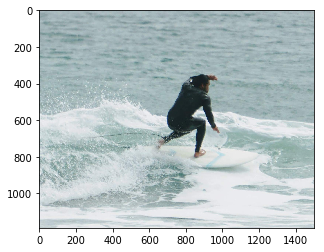

In [44]:
import json

def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)

plt.imshow(img)
plt.show()

In [45]:
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[ 93.7622,  59.6214, 165.8504, 146.9146],
         [ 88.3294,  36.8092, 177.4154, 202.8770]], grad_fn=<StackBackward>),
 'labels': tensor([1, 1]),
 'scores': tensor([0.9782, 0.2003], grad_fn=<IndexBackward>),
 'keypoints': tensor([[[148.9460,  73.7506,   1.0000],
          [148.1078,  73.4708,   1.0000],
          [146.7107,  73.4708,   1.0000],
          [118.4901, 113.4802,   1.0000],
          [140.8430,  71.5123,   1.0000],
          [145.5930,  89.4186,   1.0000],
          [123.5195,  79.9059,   1.0000],
          [143.9166, 118.2365,   1.0000],
          [151.7401, 109.2834,   1.0000],
          [136.3725, 146.7747,   1.0000],
          [104.5195, 134.1843,   1.0000],
          [124.6372, 110.6823,   1.0000],
          [110.3872, 109.0036,   1.0000],
          [144.1960, 115.4387,   1.0000],
          [145.3136, 115.9983,   1.0000],
          [136.0930, 146.7747,   1.0000],
          [106.7548, 133.0652,   1.0000]],
 
         [[149.0698,  77.4874,   1.0000],
 

In [46]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [925, 418, 1], "left_eye": [924, 406, 1], "right_eye": [919, 408, 1], "left_ear": [887, 408, 1], "right_ear": [893, 409, 1], "left_shoulder": [801, 417, 1], "right_shoulder": [907, 476, 1], "left_elbow": [838, 375, 1], "right_elbow": [925, 566, 1], "left_wrist": [910, 366, 1], "right_wrist": [951, 632, 1], "left_hip": [713, 590, 1], "right_hip": [774, 626, 1], "left_knee": [774, 663, 1], "right_knee": [887, 614, 1], "left_ankle": [686, 709, 1], "right_ankle": [863, 766, 1]}]'

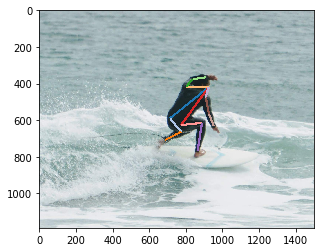

In [47]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)
        
def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)
    
def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.savefig("fig_keypoints.png",dpi=300)

draw_stickman(img, json_keypoints)

# Summary

In Part I, when we discussed a basic sport data scientist toolkit, we touched upon some of the basic tools we can use for computer vision, such as OpenCV. In Part II our focus is on deep computer vision, and in this chapter we start with some practical examples of how to perform basic deep vision tasks, such as: detection, classification, segmentation, and specifically for sports, body pose estimation. In the next chapters we’ll dive deeper into methods for 2D and 3D body pose estimation and other computer vision methods.

## Reference

[*Video Course*](http://ai-learning.vhx.tv) Need a deep dive? Watch my [*video course*](http://ai-learning.vhx.tv) that complements this book with additional examples and video-walkthroughs. 

[*Web Site*](http://activefitness.ai) for research and supplemental materials.